**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


初始化参数。

In [4]:
params = {
    'dataset_name': 'imdb',
    'sample_perecent': 1,
    'classes': ['Negative', 'Positive'],
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':20},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':5},
        'sepcnn':{'dropout':0.3, 'epochs': 20},
    }
}

params = DictToObject(params)

### 下载数据

开始下载数据。

In [5]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/aclImdb') 
if not os.path.exists(dataset_dir):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url, untar=True)
    dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    print(dataset_dir)

![image-20201217095446441](images/image-20201217095446441.png)

下面是压缩文件解开后的目录结构。

![image-20201104115404253](images/image-20201104115404253.png)

其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。

In [6]:
def get_files(base_dir):
    pos_dir = os.path.join(base_dir, 'pos')
    pos_files = os.listdir(pos_dir)
    pos_files = [os.path.join(pos_dir, file_name) for file_name in pos_files]
    
    neg_dir = os.path.join(base_dir, 'neg')
    neg_files = os.listdir(neg_dir)
    neg_files = [os.path.join(neg_dir, file_name) for file_name in neg_files]    

    return pos_files, neg_files

train_pos_files, train_neg_files = get_files(os.path.join(dataset_dir, 'train'))
test_pos_files, test_files = get_files(os.path.join(dataset_dir, 'test'))
    
print('train dataset: {} positive reviews, {} negative reviews'.format(len(train_pos_files), len(train_neg_files)))
print('test dataset: {} positive reviews, {} negative reviews'.format(len(test_pos_files), len(test_files)))

train dataset: 12500 positive reviews, 12500 negative reviews
test dataset: 12500 positive reviews, 12500 negative reviews


![image-20201217115036617](images/image-20201217115036617.png)

首先看一看正面的评论。

In [7]:
for file_path in train_pos_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...') 

------------------------------/root/.keras/datasets/aclImdb/train/pos/127_7.txt------------------------------
Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.
------------------------------/root/.keras/datasets/aclImdb/train/pos/126_10.txt------------------------------
Zentropa is the most original movie I've seen in y

![image-20201217111649607](images/image-20201217111649607.png)

然后看一看负面的评论。

In [8]:
for file_path in train_neg_files[0:3]:    
    print('-'*30 + file_path + '-'*30 )
    with open(file_path) as f:
        comment = f.read() 
        print(comment if len(comment)<=800 else comment[0:800]+' ...')

------------------------------/root/.keras/datasets/aclImdb/train/neg/127_4.txt------------------------------
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher ...
------------------------------/root/.keras/datasets/aclImdb/train/neg/126_1.txt------

![image-20201217100213645](images/image-20201217100213645.png)

## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [9]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_imdb_sentiment_analysis_dataset(imdb_data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_imdb_sentiment_analysis_dataset(dataset_dir)

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=25000, train_labels.shape=(25000,)
test_texts.length=25000, test_labels.shape=(25000,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

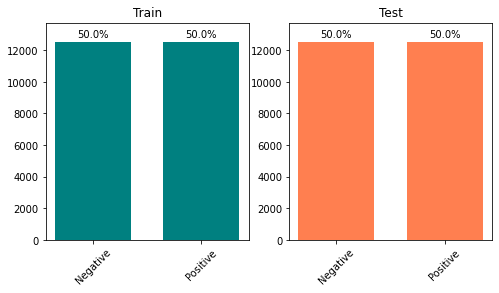

In [10]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

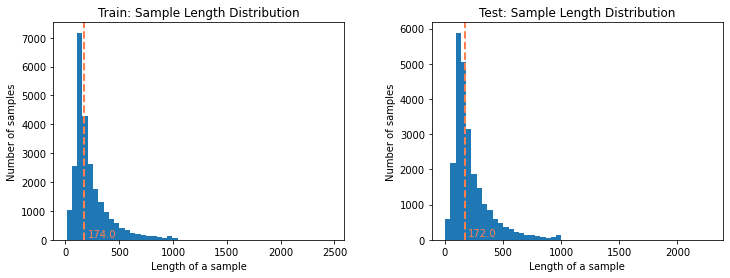

train：mean=233.79 variance=30181.96
test：mean=228.53 variance=28520.56


In [11]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [12]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3091,11744,4697,2321,1251,752,434,289,421,25000
train,2926,11654,4665,2385,1340,786,464,307,473,25000
合计,6017,23398,9362,4706,2591,1538,898,596,894,50000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
train,3008.5,11699.0,4681.0,2353.0,1295.5,769.0,449.0,298.0,447.0,25000.0
合计,6017.0,23398.0,9362.0,4706.0,2591.0,1538.0,898.0,596.0,894.0,50000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [13]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 14.229826210223425
critical_value = 15.50731305586545
p_value = 0.07596828551367163


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

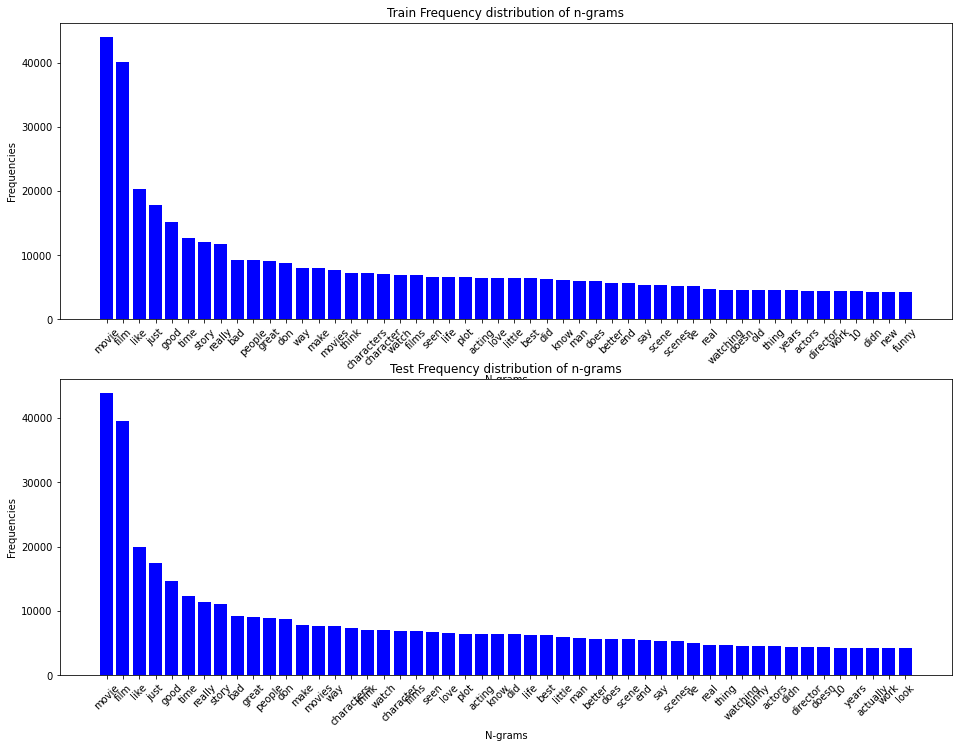

In [14]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [15]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 438729
Number of Vocabulary: 23078


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [16]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 143.7


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [17]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(25000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(25000, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 112)	0.023057178
  (0, 216)	0.02561007
  (0, 222)	0.015668478
  (0, 250)	0.029491138
  (0, 345)	0.04319149
  (0, 371)	0.015204369
  (0, 380)	0.033524606
  (0, 528)	0.023064084
  (0, 590)	0.019929541
  (0, 769)	0.06380487
  (0, 879)	0.031043448


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [18]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [19]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(25000, 500) <class 'numpy.ndarray'> int32
(25000, 500) <class 'numpy.ndarray'> int32
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [20]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset


#### TextVectorization

下面直接从原始的文件读入数据，删除无用的目录。

In [21]:
train_dir = os.path.join(dataset_dir, 'train')
print(os.listdir(train_dir))
remove_dir = os.path.join(train_dir, 'unsup')
if os.path.exists(remove_dir): shutil.rmtree(remove_dir)
print(os.listdir(train_dir))

['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']
['neg', 'pos', 'unsupBow.feat', 'labeledBow.feat', 'urls_neg.txt', 'urls_pos.txt', 'urls_unsup.txt']


![image-20210102102355896](images/image-20210102102355896.png)

把数据下载进dataset。

In [22]:
batch_size = params.batch_size
validation_split = params.validation_percent
seed = 42

if validation_split>0:
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='training', 
        seed=seed)

    print('-'*100)
    raw_val_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size, 
        validation_split=validation_split,
        subset='validation', 
        seed=seed)    
    
else:
    print('-'*100)
    raw_train_seq_ds = preprocessing.text_dataset_from_directory(
        os.path.join(dataset_dir, 'train'), 
        batch_size=batch_size)
    raw_val_seq_ds = None


print('-'*100)
raw_test_seq_ds = preprocessing.text_dataset_from_directory(
    os.path.join(dataset_dir, 'test'), 
    batch_size=batch_size)

for text_batch, label_batch in raw_train_seq_ds.take(1):
    for i in range(3):
        print('-'*50, label_batch.numpy()[i], '-'*50)
        print(text_batch.numpy()[i])
        
print('-'*100)
print("Label 0 corresponds to", raw_train_seq_ds.class_names[0])
print("Label 1 corresponds to", raw_train_seq_ds.class_names[1])       

----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
----------------------------------------------------------------------------------------------------
Found 25000 files belonging to 2 classes.
-------------------------------------------------- 0 --------------------------------------------------
b"Crude, some times crass - to me that's the summation of Madhur Bhandarkar's latest work - Page 3. He has no point of view - just shallow, funny digs at stereotypes. What is the movie about?? Is it about reporting a clan of people (so called Page 3 types) who are so busy socializing and progressing their profiles in life - that they have no time for anything else. And you are either in it or out of it. Is it that there is no press at all to report everyday incidents. Madhur Bhandarkar forgets that there is a main newspaper and Page 3 is just a supplement; perhaps an entertainer for checking out who's w

![image-20210102102702043](images/image-20210102102702043.png)

然后把进行Vectorization。

In [23]:
max_features = params.max_features
sequence_length = params.sequence_length

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_seq_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

print("7 ---> ",vectorize_layer.get_vocabulary()[7])
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

7 --->  is
1287 --->  lovely
 313 --->  idea
Vocabulary size: 20000


![image-20210102105650161](images/image-20210102105650161.png)

然后生成具体的train，validation，test数据集。

In [24]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

train_seq_ds = raw_train_seq_ds.map(vectorize_text)
if raw_val_seq_ds is not None:
    val_seq_ds = raw_val_seq_ds.map(vectorize_text)
else:
    val_seq_ds = None
test_seq_ds = raw_test_seq_ds.map(vectorize_text)

# cache data to improve the performance
train_seq_ds = train_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if val_seq_ds is not None: 
    val_seq_ds = val_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_seq_ds = test_seq_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 查看数据
vector_batch, label_batch = next(iter(train_seq_ds))
first_vector, first_label = vector_batch[0], label_batch[0]

print('Label：{}'.format(params.classes[first_label]))
print('-'*40, 'Vector', '-'*40)
print(first_vector.numpy())
print('-'*40, 'orginal review', '-'*40)
print(' '.join([vectorize_layer.get_vocabulary()[v] for v in first_vector]))

Label：Positive
---------------------------------------- Vector ----------------------------------------
[  171 12997 15681     7   277    85     6     2    81    36  1494     2
    63    32  3116   143   561     8     2 15230     5   195  2885  4322
   361   167    64   524    86     9   403     3    48    34   199    22
    75     2   531     5   252    74    47     2    19  2823    22    35
     2  5977     6     2   782   990    32  3997    20   291  4026     1
 13723     6     2  5897     3   917     5     2  4106 14785   341    17
    38  3219     5   517     3    64 11448   188    22  1007    78    64
   183     2  5888     5   223  1214  1684     1  1025   659     5     2
  7096     1     3  2699   195  2885  1186    22    75     4   376  4325
  1931     5    11  1216     5  4322  1497   280   145     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0  

![image-20210102141537073](images/image-20210102141537073.png)

![image-20210102141609143](images/image-20210102141609143.png)

##  模型

### MLP

In [25]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)

2021-01-04 09:24:18,231: INFO: start training


model_params.mlp.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
782/782 [==============================] - 5s 7ms/step - loss: 0.3651 - accuracy: 0.8422 - val_loss: 0.2498 - val_accuracy: 0.8992
Epoch 2/20
782/782 [==============================] - 5s 7ms/step - loss: 0.2347 - accuracy: 0.9031 - val_loss: 0.2378 - val_accuracy: 0.9018
Epoch 3/20
782/782 [==============================] - 5s 6ms/step - loss: 0.1998 - accuracy: 0.9166 - val_loss: 0.2426 - val_accuracy: 0.8997
Epoch 4/20
782/782 [==============================] - 5s 7ms/step - loss: 0.1853 - accuracy: 0.9229 - val_loss: 0.2390 - val_accuracy: 0.9027
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.1707 - accuracy: 0.9303 - val_loss: 0.2557 - val_accuracy: 0.8969
Epoch 6/20
782/

2021-01-04 09:26:00,220: INFO: finish training [elapsed time: 101.99 seconds]


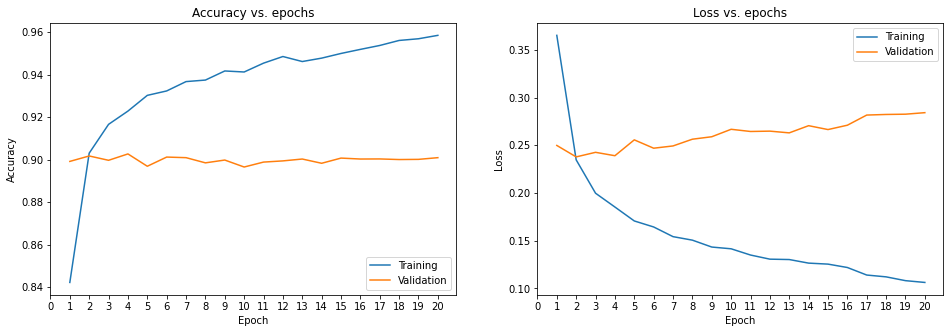

In [26]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 2s 3ms/step - loss: 0.2390 - accuracy: 0.9027
Test loss:0.2390, Test Accuracy:90.27%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 2s 2ms/step


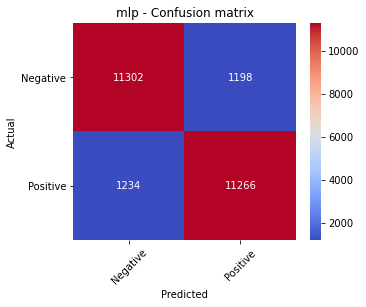

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.08787,0.9743,0.239048,0.9027,5120770,101.0


In [27]:
helper.model_summary(model, history=history)

### RNN

In [28]:
def get_rnn(helper, name='rnn', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')    
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.SimpleRNN(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_rnn(helper)
model.summary()

model_params.rnn.dropout=0.3
model_params.rnn.units=200
max_features=20000
model_params.rnn.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn/checkpoint
Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 200)          4000200   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 4,080,802
Trainable params: 4,080,802
Non-trainable params: 0
_____

2021-01-04 09:26:07,781: INFO: start training


model_params.rnn.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
781/781 [==============================] - 343s 439ms/step - loss: 0.6994 - accuracy: 0.5623 - val_loss: 0.5783 - val_accuracy: 0.7284
Epoch 2/5
781/781 [==============================] - 341s 437ms/step - loss: 0.5804 - accuracy: 0.6979 - val_loss: 0.4982 - val_accuracy: 0.7719
Epoch 3/5
781/781 [==============================] - 346s 443ms/step - loss: 0.4500 - accuracy: 0.7922 - val_loss: 0.6618 - val_accuracy: 0.5942
Epoch 4/5
781/781 [==============================] - 346s 444ms/step - loss: 0.4958 - accuracy: 0.7571 - val_loss: 0.4947 - val_accuracy: 0.7934
Epoch 5/5
781/781 [==============================] - 341s 437ms/step - loss: 0.4088 - accuracy: 0.8238 - val_loss: 0.5527 - val_accuracy: 0.7668


2021-01-04 09:54:49,376: INFO: finish training [elapsed time: 1721.59 seconds]


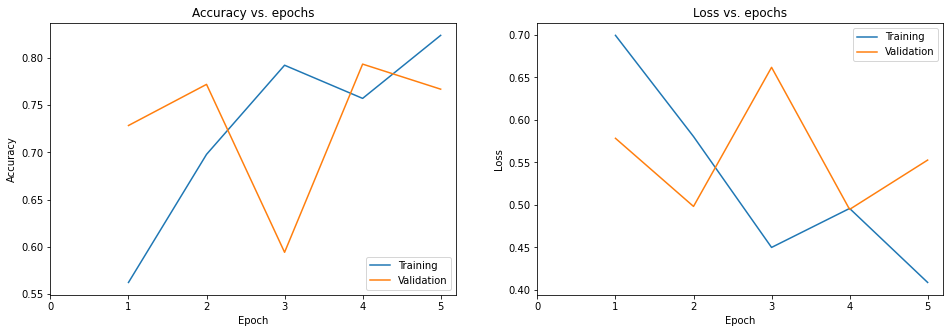

In [29]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 60s 77ms/step - loss: 0.4947 - accuracy: 0.7934
Test loss:0.4947, Test Accuracy:79.34%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 59s 76ms/step


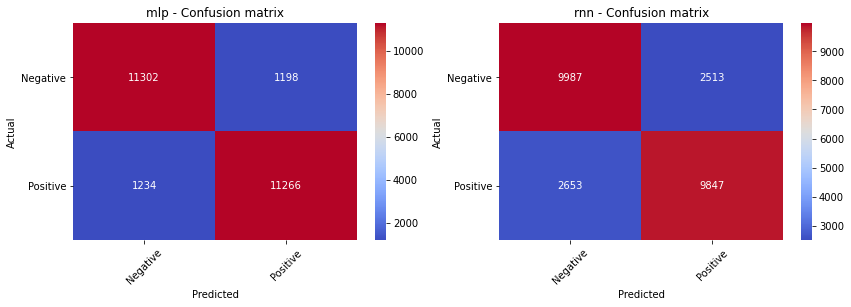

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 61s 78ms/step
........................................ Positive ........................................
Raoul Walsh's mega-epic, stunning filmed in an early widescreen process by the great Arthur Edeson, can be slow and static in the early talkie manner, but this classic wagon train journey across America to the NorthWest is thrilling as a sheer physical production when seen on the big screen. On t.v., the lack of close-ups and distant sound reproduction may prove daunting. Young John Wayne scores easily in his first starring role with a natural delivery the rest of the cast can't command. Amazingly, the film flopped and Wayne spent most of the following decade in Grade B Western fodder.


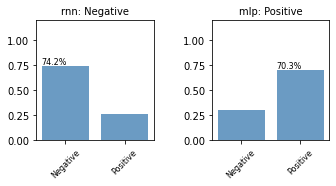

........................................ Positive ........................................
Frank Sinatra starred in this odd little short from RKO that is now in the public domain. The film came out at about the same time the war ended and is a nice plea for religious tolerance.<br /><br />The film begins with Sinatra on stage singing. After leaving the stage, he walks out into the alley and finds a group of kids picking on another because of his religion. Instead of yelling at the boys (or helping them for that matter), Sinatra delivers a nice civics lesson on religious toleration and equates prejudice with fascism. The kids seem to get the lesson but then, out of the blue, Sinatra begins singing a song that, frankly (get it?), kids would have hated. He had a lovely voice but unfortunately I think this detracted from the excellent message he gave to the kids about tolerance. It's a case of a good message with too much singing--even if the guy singing is Frank Sinatra. It's also an int

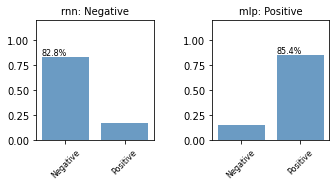

........................................ Positive ........................................
The slightly overlong set up episode of the previous week paid off in no uncertain terms with an episode that hit the heights. There was a certain deus ex machina flavour to the resolution of the cliffhanger, but it was a good start for all that. As is now common with this Doctor the moral, ethical and emotional considerations of his actions were centre stage. They were always there in the classic series, but they were a side issue, to be glossed over when the Doctor was in the heat of battle. This regeneration even says sorry to a cyberman during the battle! This episode finally shows Mickey embracing the heroic side that had been hinted at in previous episodes. His journey from zero to hero is complete, and it has been an utterly convincing one. With scares, humour and scenes that brought a lump to your throat this episode had everything. After much consideration I can finally say that the new 

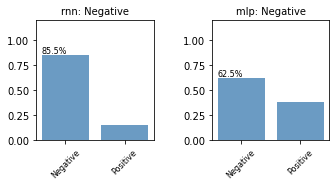

........................................ Negative ........................................
This film is all right, fairly silly and to be taken lightly. But what I can't stand are the numerous heroes and that boy's ILLEGALY SENTIMENTAL comment near the end: "look, they all look the same". Isn't that by far passing the good taste standards? I thought it was revolting, as were the heroic, unselfish acts by some of the people in this film. I'm not saying it won't happen like that, but zooming in on all the bravery like that makes my stomach churn.


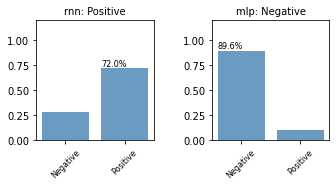

........................................ Positive ........................................
I swore I would never allow myself to devolve into to the bogus authority figures of the sixties who told me things were better in the "good old days"  the current Australian Prime Minister is a sordid example of just such a mind set.<br /><br />But I switched over to "A Decade Under the Influence" because I found watching the much-heralded "Sneakers" documentary on the other channel such a dispiriting experience. I found the values expressed by the "Sneakers" interviewees too ugly to accept as reasonable. So materialistic! So devoid of any sense of outrage at a society that can countenance killing someone to steal his very ugly shoes! So lacking in any worthwhile purpose that they can report without distaste the exploitation an audience by haranguing them to hold those shoes above their heads to lock in a sponsorship deal for themselves with a company of cobblers was just too much to continue w

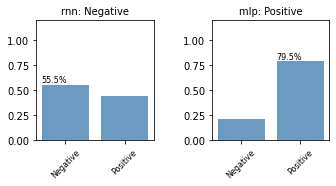

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.087870,0.9743,0.239048,0.9027,5120770,101.0
rnn,0.304334,0.8802,0.494731,0.7934,4080802,1721.0


In [30]:
helper.model_summary(model, history=history)

### LSTM

In [31]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 402       
Total params: 4,321,402
Trainable params: 4,321,402
Non-

2021-01-04 11:03:14,175: INFO: start training


model_params.rnn_lstm.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
781/781 [==============================] - 535s 685ms/step - loss: 0.0625 - accuracy: 0.9795 - val_loss: 0.6172 - val_accuracy: 0.8372
Epoch 2/5
781/781 [==============================] - 506s 648ms/step - loss: 0.0428 - accuracy: 0.9863 - val_loss: 0.5743 - val_accuracy: 0.8592
Epoch 3/5
781/781 [==============================] - 506s 647ms/step - loss: 0.0681 - accuracy: 0.9764 - val_loss: 0.6507 - val_accuracy: 0.8560
Epoch 4/5
781/781 [==============================] - 508s 650ms/step - loss: 0.0339 - accuracy: 0.9892 - val_loss: 0.8258 - val_accuracy: 0.8381
Epoch 5/5
781/781 [==============================] - 506s 648ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.7150 - val_accuracy

2021-01-04 11:45:58,331: INFO: finish training [elapsed time: 2564.16 seconds]


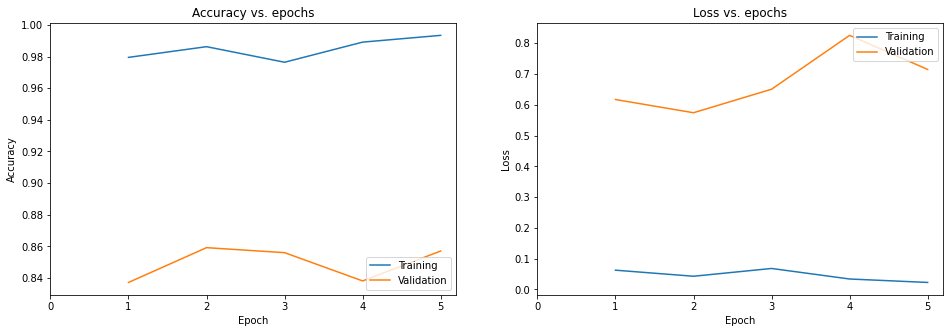

In [35]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 94s 120ms/step - loss: 0.5743 - accuracy: 0.8592
Test loss:0.5743, Test Accuracy:85.92%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 93s 119ms/step


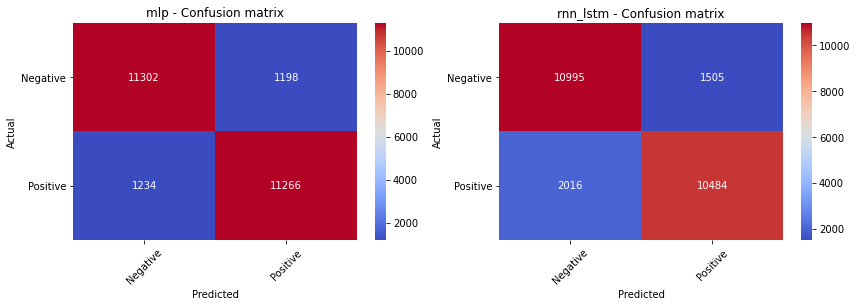

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 93s 119ms/step
........................................ Positive ........................................
I am not a footie fan by any means but watched this with a friend as there wasn't anything else on the box at the time.(thank goodness). Not only did we laugh from start to finish but about a week later in the pub, when we started discussing it, we made a right spectacle of ourselves with uncontrollable laughter. Does that sloping pitch actually exist??? I have released my e-mail here so if anyone hears about it's future availability or a repeat on the telly please let me know. Definitely the funniest thing I've seen on television!!! King Leek was good too!! another Tim Healy classic


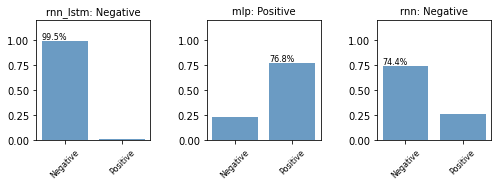

........................................ Positive ........................................
Philippe Garrel makes us breathe the forgotten atmosphere of the Nouvelle Vague, almost lost among the vestiges of its ancient splendor but ready to rise again from its ashes if recalled from the past. They who are a little acquainted with the director's subjects, on the other hand, may know very well how he's obsessed by a lingering sense of loss as far as fickleness of reality is concerned. "Les amants réguliers", therefore, show us the parallel stories of an "amour fou" and of a tempted revolution gone to ruin under the direction of young French students.<br /><br />The first part of the story is about the dramatic events of May '68 in France evoked in a series of astonishing plan-sequences, a sort of cinema verité style, that place the student insurrection in anything but an enviable light against a pitch-black background.<br /><br />There's much that can be said about the peculiarities of bl

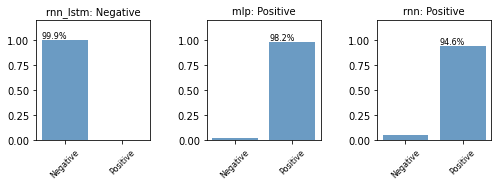

........................................ Negative ........................................
Wow. What can I say? I was born in 1960. I love bad TV movies. Love them. I get involved. The works. I want to get involved. I'm spending time watching the thing. I watched the emmys last night on TV. How in the infinite world was the Empire Falls (excellent name)TV movie up for any awards? It truly had wonderful talent. Of course. And they tried admirably. But how can ANYONE pretend that was an OK (tv for goodness sakes) screenplay? OK direction? You know, I wish everyone the best. Really. But I thought it was totally mind-bending that Hollywood was placing this very very bad film up for so many honors. Awards? For me it was sort of a wake-up call that Hollywood is such a small insular community. Being cynical is not really my thing. But wow. --xptyngi


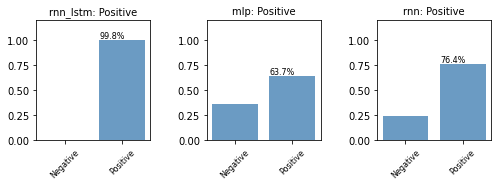

........................................ Positive ........................................
Rajkumar Santoshi tries his hands at comedy and succeeds. One of the few good movies that involves Salman Khan. A very funny movie from start to finish. All the characters contribute to the movie and believe me, there are a lot of them. Aamir Khan, Salman Khan, Raveena Tandon, Karishma Kapoor, Paresh Rawal, Viju Khote, Jagdip, Deven Verma, Shakti Kapoor, Harish Patel, Tiku Talsania and more. The direction, editing, sound are not up to par, but that still does not matter, because the actors more than make up for that part.


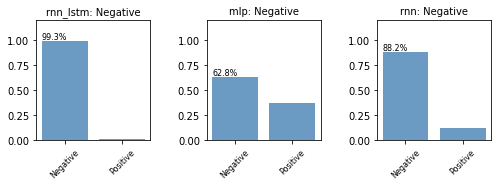

........................................ Negative ........................................
I watched the first 10 minutes of this show I think I'm gonna barf now! One worst shows on TV. It's not even funny. It's so lame it's disgusting. I gave it a second and third change couldn't even make it through five minutes. Don't waste the time. This is one of the many shows that need to go bye bye. Speaking of regular night time shows that need to go. All the shows on CBS. All the Shows on ABC. All the Shows on FOX and Joe Buck. All the shows on the new CW network. All the shows on NBC.(Accept The Law and Order series). All the Morning and Afternoon talk shows. All the Court TV shows. And every reality show out there!! Every stupid game show. period the end! All the Home improvement shows! And all the Media News. all it is.Is a 24 hour loop of bad news. Yes,I do have Favorites Monk,The law & Orders thats it for me.


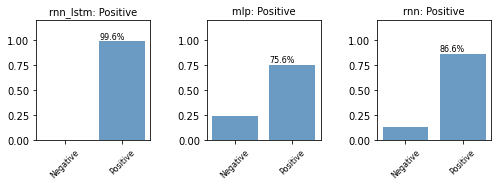

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.087870,0.9743,0.239048,0.9027,5120770,101.0
rnn_lstm,0.037693,0.9908,0.439921,0.8652,4321402,2668.0
rnn,0.304334,0.8802,0.494731,0.7934,4080802,1721.0


In [36]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [37]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
________________

2021-01-04 12:05:37,273: INFO: start training


model_params.rnn_lstm_stacked.epochs=5
use ModelCheckpoint(filepath=./checkpoints/imdb/rnn_lstm_stacked/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/5
781/781 [==============================] - 1244s 2s/step - loss: 0.5471 - accuracy: 0.7284 - val_loss: 0.3836 - val_accuracy: 0.8340
Epoch 2/5
781/781 [==============================] - 1269s 2s/step - loss: 0.2697 - accuracy: 0.8920 - val_loss: 0.3227 - val_accuracy: 0.8747
Epoch 3/5
781/781 [==============================] - 1307s 2s/step - loss: 0.1739 - accuracy: 0.9360 - val_loss: 0.3034 - val_accuracy: 0.8722
Epoch 4/5
781/781 [==============================] - 1306s 2s/step - loss: 0.1100 - accuracy: 0.9622 - val_loss: 0.3322 - val_accuracy: 0.8759
Epoch 5/5
781/781 [==============================] - 1299s 2s/step - loss: 0.0654 - accuracy: 0.9791 - val_loss: 0.4078 - val_ac

2021-01-04 13:52:58,873: INFO: finish training [elapsed time: 6441.60 seconds]


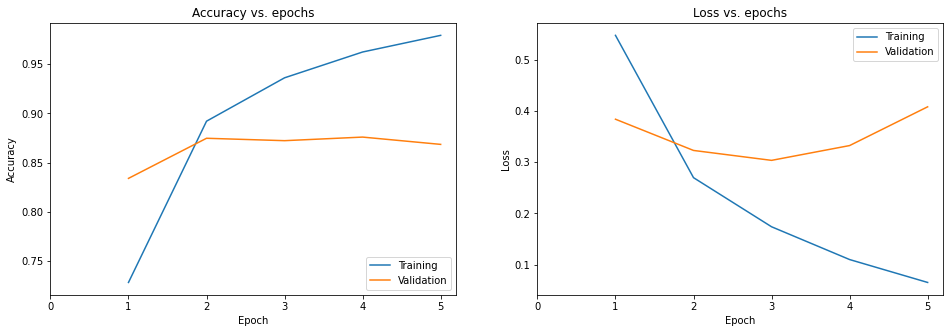

In [38]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
782/782 [==============================] - 263s 337ms/step - loss: 0.3322 - accuracy: 0.8759
Test loss:0.3322, Test Accuracy:87.59%
---------------------------------------- confusion matrix ----------------------------------------
782/782 [==============================] - 240s 306ms/step


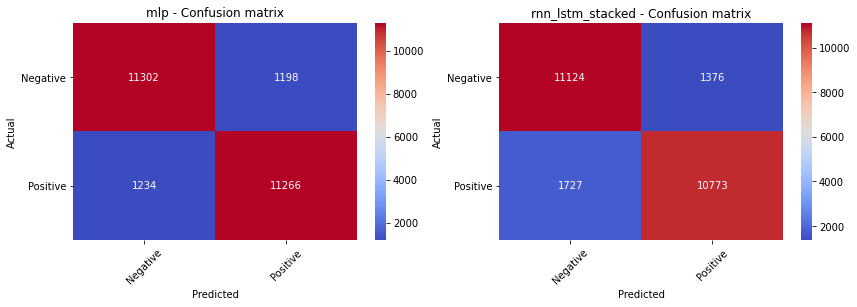

---------------------------------------- error analysis ----------------------------------------
782/782 [==============================] - 240s 306ms/step
........................................ Positive ........................................
Its very tough to portray a Tagore novel along cinematographic lines.And if you forget an obscure production of 1967 then its the first time that chokher bali has been done on a grand scale. Overall the sets looked fantastic with the right touches for making a successful period drama.Prasenjit,so used to doing crass commercial stuff made a good effort.I saw the Bengali version and found that Aishwariya's voice was dubbed,which made her dialog delivery a bit poor. While the director did a good job portraying each of the characters with finesse,yet there was very little in the way of meaningful plot,probably a lack of the story itself.However the development of the characters including those with minor roles seem to be the strongest point.Its to

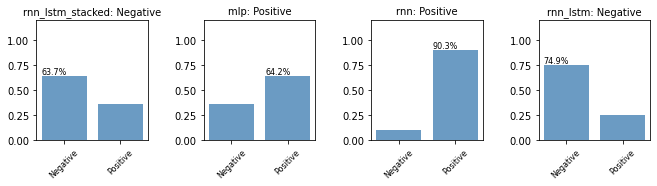

........................................ Positive ........................................
This HAS to be my guilty pleasure. I am a HUGE fan of 80's movies that were designed to entertain and they didn't care if they offended anyone. This move has no meat, not substance, no deep thought provoking scenes. Just plain old college kids having fun and if a few breasts have to be shown, then so be it! This movie is for when you just want to relax and NOT think. Viva la nudity!


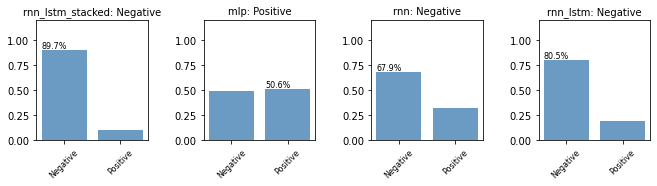

........................................ Negative ........................................
This is defiantly a DVD rental movie. I'm a big fan of the cast members but the storyline never really grabbed me. Don't expect "Oh brother where art thou" in any way shape or form. Funniest part in my opinion is when the war hero explains what happens over in the Argon. Seems like they were trying to copy some of Clooney's funny facial expressions from "Oh brother where art thou" but you could kind of tell they were trying for that. John Krasinski was the bright spot and was solid throughout. Renee Zellweger plays the part of a zealous reporter willing to do whatever for the story. Overall it's a movie worth watching at home.


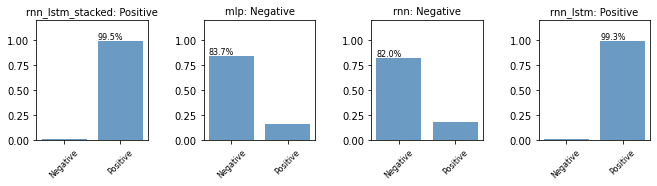

........................................ Negative ........................................
Check out the two octogenarians who review Leatherheads. These guys are old-school Hollywood and a hit on YouTube. They always give an insightful and fun review. They have movie comparisons that are really interesting and they have a banter back and forth that is endlessly entertaining. They know movies, collectively they have been in the biz for practically a century. Lorenzo is a well-known screenwriter and Marcia is a famous producer. All of their insight on movies always leaves you with something to think about. See what they think about Clooney's latest...<br /><br />http://www.youtube.com/watch?v=2-W7evBEArs


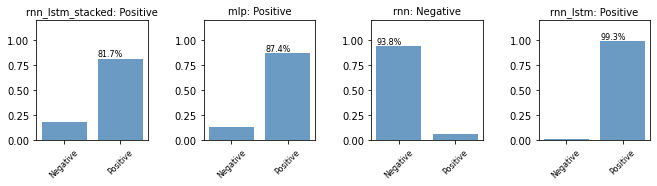

........................................ Positive ........................................
"The Charge at Feather River" is a routine Western about the U. S. Cavalry against the Cheyenne Indians... The film carried a constantly mounting tension with some pleasant diversion...<br /><br />Guy Madison and Frank Lovejoy play the officers who rescue Helen Westcott and Vera Miles from the Indians...<br /><br />The outdoor scenes are well photographed, specially the exciting Indian charge at Feather River at the climax of the movie with the rain of spears, the fight to-the-death between Madison and Thunderhawk, the sketches of the Guardhouse Brigade, even a mouthful of tobacco juice used against a rattlesnake, and the romantic interludes between our hero and Helen Westcott... All are here, pictorially entertaining in 3-D and Technicolor...


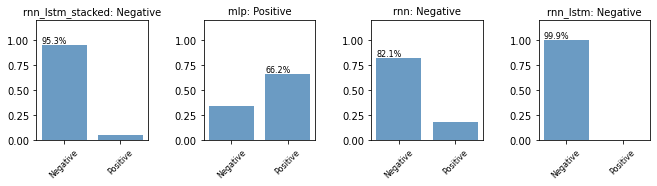

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.087870,0.9743,0.239048,0.9027,5120770,101.0
rnn_lstm_stacked,0.057827,0.9862,0.332243,0.8759,5123002,6441.0
rnn_lstm,0.037693,0.9908,0.439921,0.8652,4321402,2668.0
rnn,0.304334,0.8802,0.494731,0.7934,4080802,1721.0


In [39]:
helper.model_summary(model, history=history)

### sepCNN

In [40]:
def get_sepcnn(helper,
                 blocks=2,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(layers.Dropout(rate=dropout))
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.SeparableConv1D(filters=filters * 2,
                                     kernel_size=kernel_size,
                                     activation='relu',
                                     bias_initializer='random_uniform',
                                     depthwise_initializer='random_uniform',
                                     padding='same'))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(2))
    helper.compile(model)  
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper)
model.summary()

model_params.sepcnn.dropout=0.3
learning_rate=0.001
checkpoint_path=./checkpoints/imdb/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 64)           13464     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 64)           4352      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 64)           0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 166, 128)          8512      
_____________________

In [41]:
history = helper.train(model)

2021-01-04 14:10:06,275: INFO: start training


model_params.sepcnn.epochs=20
use ModelCheckpoint(filepath=./checkpoints/imdb/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
 11/781 [..............................] - ETA: 19s - loss: 0.6962 - accuracy: 0.4631

2021-01-04 14:10:09,349: INFO: finish training [elapsed time: 3.07 seconds]


InternalError: 2 root error(s) found.
  (0) Internal:  cuDNN launch failure : input shape([32,200,1,500]) filter shape([1,1,200,64])
	 [[node sepcnn/separable_conv1d/separable_conv2d (defined at /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code/text_classification.py:423) ]]
  (1) Internal:  cuDNN launch failure : input shape([32,200,1,500]) filter shape([1,1,200,64])
	 [[node sepcnn/separable_conv1d/separable_conv2d (defined at /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code/text_classification.py:423) ]]
	 [[gradient_tape/sepcnn/embedding_3/embedding_lookup/Reshape/_24]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_213776]

Function call stack:
train_function -> train_function


In [ ]:
helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)